<a href="https://colab.research.google.com/github/ahmedrazagit/Dubai-Satellite-Image-MachineLearning/blob/main/SatelliteDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install patchify

In [7]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [8]:
minmaxscaler = MinMaxScaler()

In [9]:
!ls -lah '/content/drive/MyDrive/archive/Semantic-segmentation-dataset'

total 33K
-rw------- 1 root root  548 Sep  9 13:21  classes.json
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 1'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 2'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 3'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 4'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 5'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 6'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 7'
drwx------ 4 root root 4.0K Sep  9 13:36 'Tile 8'


In [10]:
dataset_root_folder = '/content/drive/MyDrive/archive'

In [11]:
dataset_name = "Semantic-segmentation-dataset"

In [12]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks': # 'images
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')): # '.jpg
        #print(image_name)
        a = True

/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 4/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 7/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 8/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 5/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 1/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 2/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 3/masks
/content/drive/MyDrive/archive/Semantic-segmentation-dataset/Tile 6/masks


In [13]:
image_patch_size = 256

In [14]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)

In [15]:
image.shape

(544, 509, 3)

In [16]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [17]:
len(image_patches)

2

In [18]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [19]:
minmaxscaler = MinMaxScaler()

In [20]:
image_x = image_patches[0,0,:,:]
#MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [21]:
image_y[0].shape

(256, 256, 3)

In [22]:
print(type(image))

<class 'numpy.ndarray'>


In [23]:
type(Image.fromarray(image))

PIL.Image.Image

In [24]:
image.shape

(544, 509, 3)

In [25]:
(image.shape[0]//image_patch_size)*image_patch_size

512

In [26]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [27]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [28]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [29]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [30]:
type(image_dataset[0])

numpy.ndarray

In [31]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

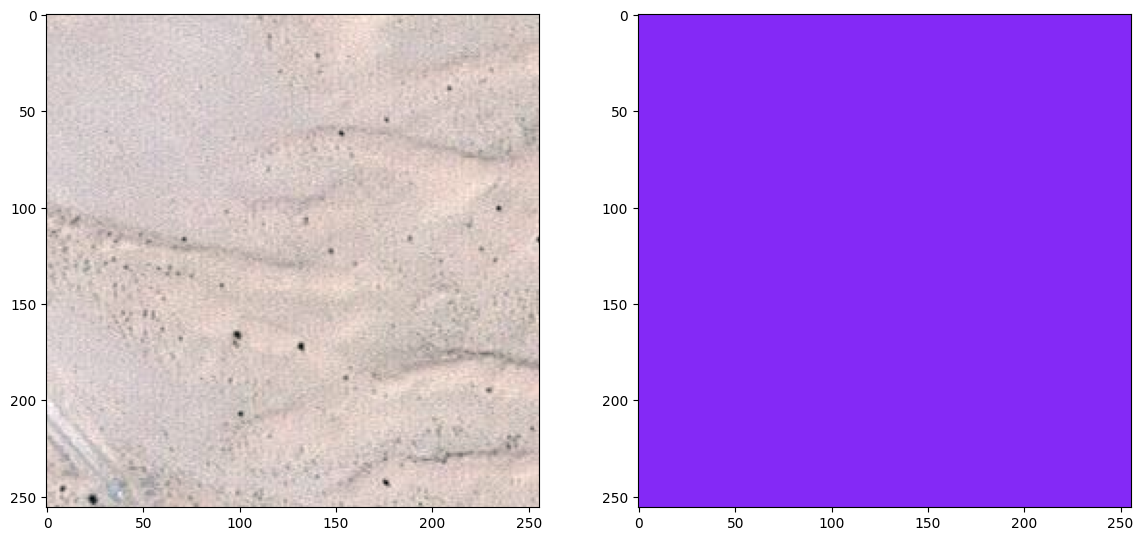

In [32]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [33]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [34]:
mask_dataset.shape[0]

945

In [35]:
label = individual_patched_mask

In [36]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [37]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [38]:
print(len(labels))

945


In [39]:
labels = np.array(labels)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
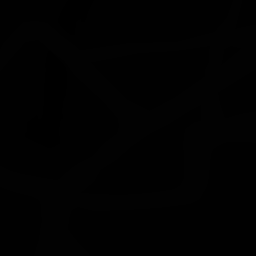

In [40]:
labels[3]

In [41]:
labels = np.expand_dims(labels, axis=3)

In [42]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [43]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [44]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


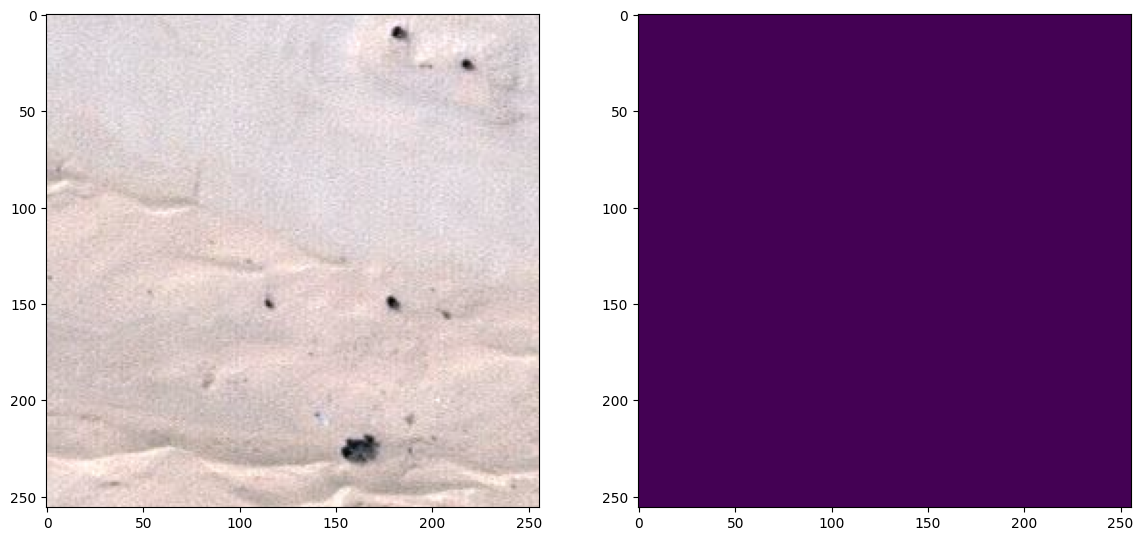

In [45]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
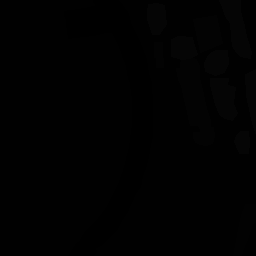

In [46]:
labels[0][:,:,0]

In [47]:
total_classes = len(np.unique(labels))

In [48]:
total_classes

6

In [49]:
from tensorflow.keras.utils import to_categorical

In [50]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [51]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [54]:
master_training_dataset.shape

(945, 256, 256, 3)

In [53]:
master_training_dataset = image_dataset

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [58]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [59]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6
